In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

2021-08-08 23:44:15.471553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-08 23:44:15.471589: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
image_size = (200, 271)
batch_size = 12

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    labels="inferred",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    labels="inferred",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 204 files belonging to 2 classes.
Using 164 files for training.
Found 204 files belonging to 2 classes.
Using 40 files for validation.


2021-08-08 23:44:17.253943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-08 23:44:17.253968: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-08 23:44:17.253990: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (trieste): /proc/driver/nvidia/version does not exist
2021-08-08 23:44:17.254260: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2021-08-08 23:44:17.330491: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-08 23:44:17.350932: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999965000 Hz


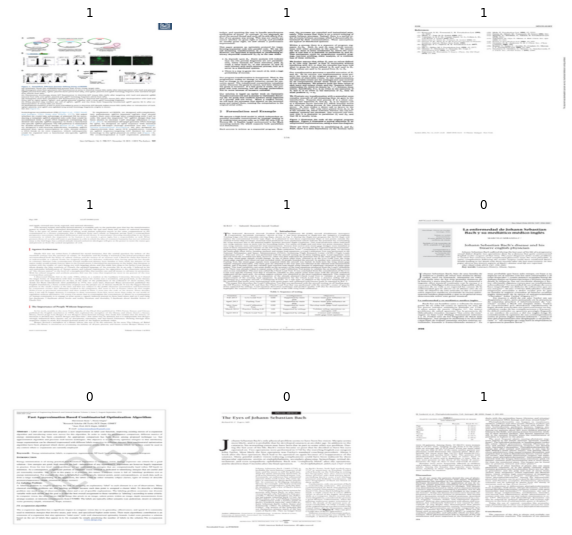

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


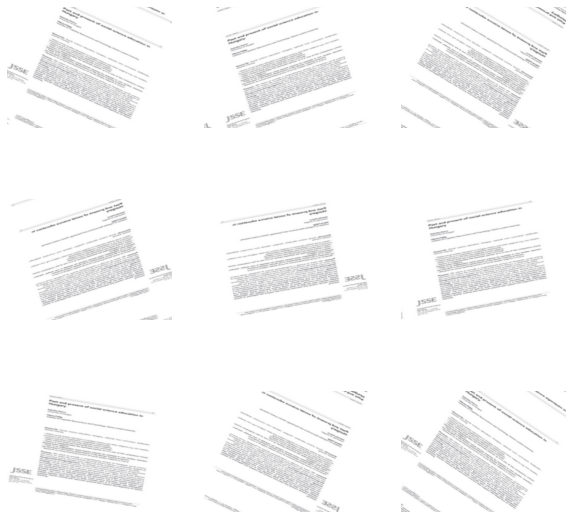

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [8]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)


In [11]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/50


2021-08-08 23:44:56.479493: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 83558400 exceeds 10% of free system memory.
2021-08-08 23:44:56.510367: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 83558400 exceeds 10% of free system memory.
2021-08-08 23:44:56.589187: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 83558400 exceeds 10% of free system memory.
2021-08-08 23:44:56.646364: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 83558400 exceeds 10% of free system memory.
2021-08-08 23:44:56.703342: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 83558400 exceeds 10% of free system memory.


14/14 [==============================] - 35s 2s/step - loss: 0.7778 - accuracy: 0.5366 - val_loss: 0.6941 - val_accuracy: 0.5000


/home/tir/.virtualenvs/flyleaf/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
14/14 [==============================] - 33s 2s/step - loss: 0.5737 - accuracy: 0.7195 - val_loss: 0.6959 - val_accuracy: 0.5000
Epoch 3/50
14/14 [==============================] - 34s 2s/step - loss: 0.5405 - accuracy: 0.7744 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 4/50
14/14 [==============================] - 32s 2s/step - loss: 0.5399 - accuracy: 0.7744 - val_loss: 0.7023 - val_accuracy: 0.5000
Epoch 5/50
14/14 [==============================] - 34s 2s/step - loss: 0.4565 - accuracy: 0.7866 - val_loss: 0.7379 - val_accuracy: 0.5000
Epoch 6/50
14/14 [==============================] - 32s 2s/step - loss: 0.4371 - accuracy: 0.8171 - val_loss: 0.7519 - val_accuracy: 0.5000
Epoch 7/50
14/14 [==============================] - 33s 2s/step - loss: 0.4023 - accuracy: 0.8110 - val_loss: 0.8210 - val_accuracy: 0.5000
Epoch 8/50
14/14 [==============================] - 32s 2s/step - loss: 0.4653 - accuracy: 0.8354 - val_loss: 0.8903 - val_accuracy: 0.5000
Epoch 9/50
14/14 [==

In [13]:
model.save("models/flyleaf.20210809001333")

2021-08-09 00:15:29.990512: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/tir/.virtualenvs/flyleaf/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models/flyleaf.20210809001333/assets
